In [33]:
import pandas as pd
import numpy as np 

import json
from pandas.io.json import json_normalize

import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import folium

from bs4 import BeautifulSoup
import geopy
import requests

In [2]:
url_mumbai='https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
url_delhi='https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Delhi'

In [11]:
def mumbai_neighbor(url_mumbai):
    neighbor_mumbai=[]
    result=requests.get(url_mumbai).text
    soup=BeautifulSoup(result,'html.parser')
    for i in soup.find_all('h3'):
        x=i.find('a')
        try:
            neighbor_mumbai.append(x.next_element)
        except:
            pass
    return neighbor_mumbai

In [12]:
def delhi_neighbor(urld):
    neighbor_delhi=[]
    html_data_delhi=requests.get(url_delhi).text
    soup_delhi=BeautifulSoup(html_data_delhi,'html.parser')
    for i in soup_delhi.find_all('li'):
        try:
            x=i.a   
            if '<' in str(x.next_element):
                pass
            else:
                neighbor_delhi.append(x.next_element)
        except:
            neighbor_delhi.append(list(i.descendants)[0])
    return neighbor_delhi[:119]

In [13]:
delhi_neighbors=delhi_neighbor(url_delhi)

In [14]:
def location_finder(x,state):
    address='{}, {}'.format(x['Neighborhood'],state)
    geolocator=geopy.geocoders.Nominatim(user_agent='neighod')
    g=geolocator.geocode(address)
    try:
        x.loc['Latitude']=g.latitude
        x.loc['Longitude']=g.longitude
        x.loc['Importance']=g.raw['importance']
    except:
        x.loc['Latitude']=np.nan
        x.loc['Longitude']=np.nan
        x.loc['Importance']=np.nan


In [15]:
def dataframe_creation(data_list,state):
    columns=['Neighborhood','Latitude','Longitude','Importance']
    dataframe=pd.DataFrame(columns=columns)
    dataframe['Neighborhood']=data_list
    dataframe.apply(location_finder,axis=1,args=(state,))
    return dataframe

In [16]:
delhi_dataframe=dataframe_creation(delhi_neighbors,'Delhi')
delhi_dataframe

,Neighborhood,Latitude,Longitude,Importance
0,Adarsh Nagar,28.7166,77.1704,0.708428
1,Ashok Vihar,28.6995,77.1848,0.311
2,Begum Pur,28.7255,77.0584,0.585
3,Karala,28.7351,77.0325,0.47
4,Narela,28.8426,77.0918,0.500666
...,...,...,...,...
114,Rajouri Garden,28.6451,77.1239,0.56
115,Tihar Village,28.6346,77.1071,0.373151
116,Tilak Nagar,28.6365,77.0965,0.682128
117,Vikas Nagar,28.644,77.0545,0.56


In [17]:
delhi_dataframe.to_csv('Data/delhi_dataframe.csv')

In [18]:
mumbai_neighbors=mumbai_neighbor(url_mumbai)

In [19]:
mumbai_dataframe=dataframe_creation(mumbai_neighbors,'Mumbai')

In [20]:
mumbai_dataframe

,Neighborhood,Latitude,Longitude,Importance
0,Andheri,19.1197,72.8464,0.580152
1,Mira-Bhayandar,19.2821,72.8741,0.311
2,Bandra,19.055,72.8402,0.559056
3,Borivali,19.2291,72.8574,0.58818
4,Dahisar,19.2495,72.8596,0.572959
5,Goregaon,19.1648,72.85,0.557785
6,Jogeshwari,19.1349,72.8488,0.498689
7,Juhu,19.107,72.8275,0.598549
8,Kandivali west,19.2084,72.8422,0.585
9,Kandivali east,19.2104,72.8641,0.585


In [56]:
def map_creater(dataframe,state,user_agent='map_default'):
    geolocator=geopy.geocoders.Nominatim(user_agent=user_agent)
    g=geolocator.geocode(state)
    map_created=folium.Map(location=[g.latitude,g.longitude],zoom_start=11)
    for index,row in dataframe.iterrows():
        if row.Latitude is not np.nan or row.Longitude is not np.nan:
            array=plt.cm.viridis(row['Importance'])
            color=colors.rgb2hex(array)
            label='{},{}'.format(row['Neighborhood'],state)
            label=folium.Popup(label,parse_html=False)
            folium.CircleMarker(location=[row['Latitude'],row['Longitude']],
                                radius=row['Importance']*10,
                                weight=2,
                                color='black',
                                fill=True,
                                fill_color=color,
                                fill_opacity =0.8,
                                popp=label).add_to(map_created)
    return map_created

In [57]:
map_creater(delhi_dataframe,'Delhi')


In [58]:
map_creater(mumbai_dataframe,'Mumbai')

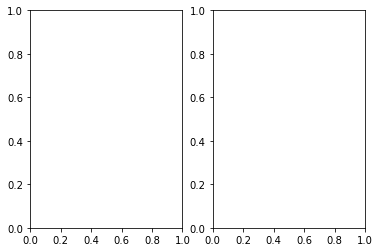

In [65]:
fig,ax=plt.subplot(1,2,1)

'#f7a98b'